In [5]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
from scipy.optimize import least_squares

In [6]:
@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr

def phase_pred(fit_coords, info, pulse_idx):
    
    ref_coords = coords[0]

    relative_start_time = info[pulse_idx][0][0]
    pulse_duration_sec = info[pulse_idx][0][1] - info[pulse_idx][0][0]
    pulse_duration_chunks = int( pulse_duration_sec / (T_SPECTRA * v_acclen) )


    time_start = global_start_time + relative_start_time
    sat_ID = info[pulse_idx][1]

    pulse_channel_idx = info[pulse_idx][2]
    pulse_freq = outils.chan2freq(pulse_channel_idx, alias=True)

    # 'd' has one entry per second
    d = outils.get_sat_delay(ref_coords, fit_coords, tle_path, time_start, visibility_window+1, sat_ID)
    # 'delay' has one entry per chunk (~0.5s) 
    delay = np.interp(np.arange(0, v_nchunks) * v_acclen * T_SPECTRA, np.arange(0, int(visibility_window)+1), d)
    #thus 'pred' has one entry for each chunk
    pred = (-delay[:pulse_duration_chunks]+ delay[0]) *  2*np.pi * pulse_freq

    return pred

def get_residuals(coordinates):
    all_res = []
    for pulse_idx, observed_data in enumerate(data):
        predicted = phase_predictor(coordinates, pulse_idx)
        res = predicted - observed_data
        all_res.append(res)
    return np.concatenate(all_res)  # Returns a single long 1D array

STANDARDIZED INITIAL VARBS

In [7]:
T_SPECTRA = 4096/250e6

visibility_window = 1000

c_acclen = 10**6 
v_acclen = 30000

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

#---------Data-specific--------

data_version = "MANUAL TESTER"

if data_version == "MANUAL TESTER":

    a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
    a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"

    global_start_time = 1721800002

    a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
    a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2

elif data_version == "SATDET TESTER":

    a1_coords = [79.41718333333333, -90.76735, 189]
    a2_coords = [79.41721666666666, -90.75885, 176] #ant2
    a3_coords = [79.41541666666667, -90.77308333333333, 175] #ant3

    a1_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_1_central"
    a2_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_2_east" #ant2
    a3_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_3_west" #ant3

    global_start_time = 1699625045


tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

dir_parents = []
dir_parents.append(a1_path)
dir_parents.append(a2_path)

coords = []
coords.append(a1_coords)
coords.append(a2_coords)

In [8]:
#all these are detected. These numbers are the result of all the stuff above. What we care about starts now.


if data_version == "MANUAL TESTER":
        info = [[[715, 1110], 28654, 1836, 86568], 
                [[4950, 5270], 59051, 1836, 109993], 
                [[7000, 7145], 28654, 1836, 109993], 
                [[10975, 11440],59051, 1836, 86568],
                [[17005, 17530], 59051, 1837, 86568] ]

elif data_version == "SATDET TESTER":
        info = [[[0, 215], 33591, 16, 77396]]
                
                #[[505, 765], 28654, 2, 67385],
                #[[1815, 2250], 57166, 2, 53673],
                #[[4730, 4940], 25338, 7, 71541]]


In [14]:
observed_data = []
time_total = time.time()
for pulse_idx in range(len(info)):

    print(f"---------STARTING PULSE {pulse_idx}---------")

    #--------times-----
    relative_start_time = info[pulse_idx][0][0]
    pulse_duration_chunks = int(  (info[pulse_idx][0][1] - info[pulse_idx][0][0]) / (T_SPECTRA * v_acclen)  )
    t_start = global_start_time + relative_start_time
    t_end = t_start + visibility_window

    #----get initialized information----
    files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
    files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

    #------get corrected offsets-----
    idx_correction = info[pulse_idx][3] - 100000
    if idx_correction>0:
        idx1_v = idx1 + idx_correction
        idx2_v = idx2
    else:
        idx2_v = idx2 + np.abs(idx_correction)
        idx1_v = idx1
    #print("Corrected Starting Indices:", idx1_v, idx2_v)

    #-------set up channels-------
    channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
    chanstart = np.where(channels == 1834)[0][0] 
    chanend = np.where(channels == 1852)[0][0]
    nchans=chanend-chanstart

    chan_bigidx = info[pulse_idx][2]
    chanmap = channels[chanstart:chanend].astype(int)
    chan_smallidx = np.where(chanmap == chan_bigidx)[0][0]

    #--------open object----------
    ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')
    ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')

    #--------get visibilities-----
    m1=ant1.spec_num_start
    m2=ant2.spec_num_start

    visibility_phased = np.zeros((v_nchunks,len(ant1.channel_idxs)), dtype='complex64')
    time_pulse=time.time()
    #print(f"--------- Processing Pulse Idx {pulse_idx} ---------")
    for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
            xcorr = avg_xcorr_4bit_2ant_float(
                chunk1['pol0'], 
                chunk2['pol0'],
                chunk1['specnums'],
                chunk2['specnums'],
                m1+i*v_acclen,
                m2+i*v_acclen)
            visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
            #print("CHUNK", i, " has ", xcorr.shape[0], " rows")
    print(f"DONE PULSE {pulse_idx}. TIME:", time.time()-time_pulse)
    visibility_phased = np.ma.masked_invalid(visibility_phased)
    vis_phase = np.angle(visibility_phased)
    obs = np.unwrap(vis_phase[0:pulse_duration_chunks, chan_smallidx])
    observed_data.append(obs)
    
print("Done with everything. Time taken:", time.time() - time_total)

---------STARTING PULSE 0---------
Not reading any data
ACCLEN RECEIVED IS 30000
took 0.245 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800712.raw
START SPECNUM IS 1033442694 obj start at 1033137518
ACCLEN RECEIVED IS 30000
took 1.451 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721800684.raw
START SPECNUM IS 1089686353 obj start at 1087658761
took 1.433 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721800729.raw
took 1.471 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800757.raw
took 1.501 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721800773.raw
took 1.380 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800801.raw
took 1.422 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721800817.raw
took 1.458 seconds to read 

catalog #28654 epoch 2024-07-24 20:56:55 UTC


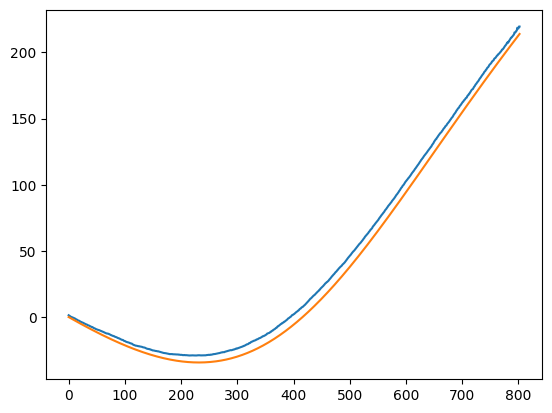

In [13]:
plt.plot(observed_data[0])

plt.plot(phase_pred(a2_coords, info, 0))